In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
import hashlib

def test_group(x, seed, size):
    hash_sha256 = hashlib.sha256(f"{seed}_{x}".encode())
    return int(hash_sha256.hexdigest(), 16)%size

# ログデータ

In [3]:
rows=[]
for i in range(10000):
    impression=np.random.randint(1000)
    click=np.random.randint(
        impression+1 if np.random.randint(2) else int(np.sqrt(impression))+1
    )
    rows+=[{"user_id": i, "click": 1}]*click+[{"user_id": i, "click": 0}]*(impression-click)
log=pd.DataFrame(rows)
log

,user_id,click
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
4961982,9999,0
4961983,9999,0
4961984,9999,0
4961985,9999,0


# 間違った分散

In [4]:
log["group"]=log["user_id"].map(lambda x: test_group(x, "example", size=2))

In [5]:
naive_var=log.groupby("group")["click"].var(ddof=1)
naive_var

group
0    0.187910
1    0.189427
Name: click, dtype: float64

In [6]:
size=log.groupby("group")["click"].size()
size

group
0    2489230
1    2472757
Name: click, dtype: int64

In [7]:
np.sqrt((naive_var/size).sum())

0.00038999331153714373

In [8]:
# 間違った分散を使った検定: 有意差が出てしまう
mean=log.groupby("group")["click"].mean()
z=(mean[0]-mean[1])/np.sqrt((naive_var/size).sum())
p=norm.cdf(-np.abs(z))*2
p

4.209592533114298e-15

# ブートストラップ

In [9]:
# ランダム化単位で集計したテーブルを作成する
df=log.groupby("user_id")["click"].agg(["count", "sum"]).rename(
    columns={"count":"impression", "sum":"click"}).reset_index()
df

,user_id,impression,click
0,0,290,16
1,1,551,17
2,2,209,3
3,3,300,16
4,4,873,261
...,...,...,...
9985,9995,112,89
9986,9996,202,73
9987,9997,522,475
9988,9998,896,327


In [10]:
# 2つのグループに分ける
df["group"]=df["user_id"].map(lambda x: test_group(x, "example", size=2))

In [11]:
df.groupby("group").size()

group
0    5031
1    4959
dtype: int64

In [12]:
def sampling_click_rate(df, group):
    tmp=df[df["group"]==group]
    tmp=tmp.sample(n=tmp.shape[0], replace=True)
    return tmp["click"].sum()/tmp["impression"].sum()

In [13]:
# 正しい標準偏差を推定
diffs = [
    sampling_click_rate(df, 0) - sampling_click_rate(df, 1)
    for i in range(1000)
]
np.std(diffs, ddof=1)

0.007500048590579285

In [14]:
# 検定
mean=df.groupby("group")["click"].sum()/df.groupby("group")["impression"].sum()
z=(mean[0]-mean[1])/np.std(diffs, ddof=1)
p=norm.cdf(-np.abs(z))*2
p

0.6831902403499597

# デルタ法

In [15]:
def var_delta(df, group):
    tmp=df[df["group"]==group]
    
    meanX=tmp["click"].mean()
    meanY=tmp["impression"].mean()
    varX=tmp["click"].var(ddof=1)
    varY=tmp["impression"].var(ddof=1)
    covXY=np.cov(tmp["impression"],tmp["click"], ddof=1)[0,1]

    return (varX/meanY**2 + meanX**2/meanY**4 * varY - 2*meanX/meanY**3 * covXY)/tmp.shape[0]

In [16]:
# 正しい標準偏差を推定
np.sqrt(var_delta(df, 0)+var_delta(df, 1))

0.007218099140783204

In [17]:
# 検定
mean=df.groupby("group")["click"].sum()/df.groupby("group")["impression"].sum()
z=(mean[0]-mean[1])/np.sqrt(var_delta(df, 0)+var_delta(df, 1))
p=norm.cdf(-np.abs(z))*2
p

0.6715255852277127

# AA test

## 間違った分散を使った場合

In [18]:
p_value=[]
users=log["user_id"].unique()
for i in tqdm(range(1000)):
#     log["group"]=log["user_id"].map(lambda x: test_group(x, f"example{i}", size=2))
#     naive_var=log.groupby("group")["click"].var(ddof=1)
#     size=log.groupby("group")["click"].size()
#     mean=log.groupby("group")["click"].mean()

    groupA=log["user_id"].isin([x for x in users if 0==test_group(x, f"example{i}", size=2)])
    naive_varA=log.loc[groupA, "click"].var(ddof=1)
    naive_varB=log.loc[~groupA, "click"].var(ddof=1)
    sizeA=log.loc[groupA,"click"].shape[0]
    sizeB=log.loc[~groupA,"click"].shape[0]
    meanA=log.loc[groupA, "click"].mean()
    meanB=log.loc[~groupA, "click"].mean()

    z=(meanA-meanB)/np.sqrt((naive_varA/sizeA+naive_varB/sizeB).sum())
    p=norm.cdf(-np.abs(z))*2
    p_value.append(p)

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([921.,  17.,  12.,   6.,   6.,  12.,   3.,   7.,   8.,   8.]),
 array([0.        , 0.09777707, 0.19555413, 0.2933312 , 0.39110827,
        0.48888534, 0.5866624 , 0.68443947, 0.78221654, 0.87999361,
        0.97777067]),
 <BarContainer object of 10 artists>)

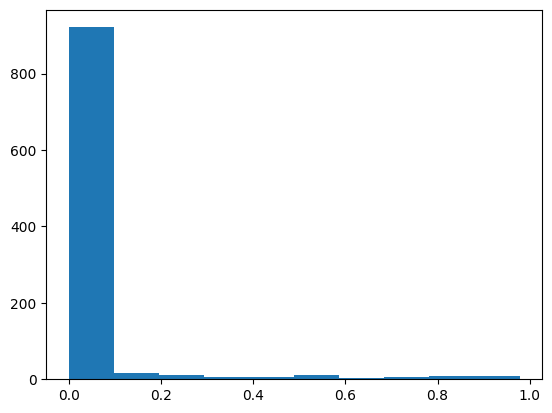

In [19]:
plt.hist(p_value, bins=10)

## 正しい分散を使った場合

In [20]:
p_value=[]
for i in tqdm(range(1000)):
    df["group"]=df["user_id"].map(lambda x: test_group(x, f"example{i}", size=2))
    mean=df.groupby("group")["click"].sum()/df.groupby("group")["impression"].sum()
    z=(mean[0]-mean[1])/np.sqrt(var_delta(df, 0)+var_delta(df, 1))
    p=norm.cdf(-np.abs(z))*2
    p_value.append(p)

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([105.,  99.,  97., 101.,  91., 111.,  98.,  99.,  93., 106.]),
 array([0.00105882, 0.10083281, 0.20060681, 0.30038081, 0.40015481,
        0.4999288 , 0.5997028 , 0.6994768 , 0.79925079, 0.89902479,
        0.99879879]),
 <BarContainer object of 10 artists>)

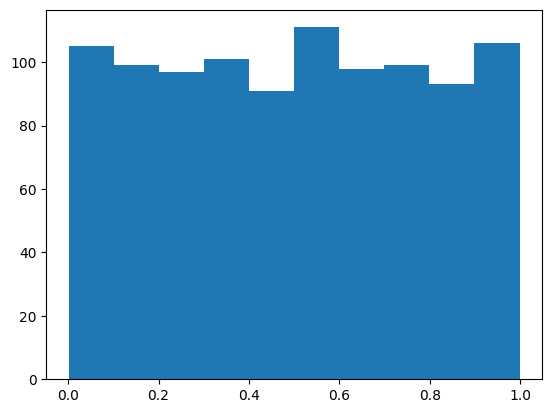

In [21]:
plt.hist(p_value, bins=10)